Extra package install (install in conda env)

# Load data file
Read headlines file and add to variable:content

In [1]:
import os
pwd = os.getcwd()
path = os.path.join(pwd, "data", "headlines.txt")

f = open(path,"r")
lines = f.readlines()
f.close()




# Build regular expression from cities

In [2]:
import re
import geonamescache
from unidecode import unidecode

def byLength(e):
    return len(e)

gc = geonamescache.GeonamesCache()
cityNames = []
for city in gc.get_cities().values():
        name = city['name']
        normalizedName = unidecode(city['name'])
        cityNames.append(normalizedName)

#sort from long to short (want to match on long names first)
cityNames.sort(reverse=True, key=byLength)

orCities = "|".join(cityNames)
regex = "\\b(" + orCities + ")\\b"
compiled_re = re.compile(regex)

# Add headline, city and country code to panda data frame

In [3]:
import re
import geonamescache
from unidecode import unidecode
import pandas as pd 

df = pd.DataFrame(columns =['headline', 'city', 'country']) 

for line in lines:
    m = compiled_re.search(line)
    if m != None:
        cityName = line[m.start():m.end()]
        cities = gc.get_cities_by_name(cityName)
        if len(cities)==0:
            df = df.append({'headline' : line, "city" : "" , "country" : ""} , ignore_index=True)
        else:
            
            largestCityAttr = {}
            for city in cities:
                #there should only be one
                for cityKey in city.keys():
                    cityAttr = city[cityKey]
                    if len(largestCityAttr)==0:
                        largestCityAttr=cityAttr
                    else:
                        if cityAttr["population"] > largestCityAttr["population"]:
                            largestCityAttr = cityAttr
            df = df.append({'headline' : line, "city" : largestCityAttr["name"] , "country" : largestCityAttr["countrycode"]} , ignore_index=True)
    else:
        df = df.append({'headline' : line, "city" : "" , "country" : ""} , ignore_index=True)
    
print(df)

pwd = os.getcwd()
path = os.path.join(pwd, "data", "cities2headlines.csv")

df.to_csv(path, index=False)

                                              headline           city country
0                           Zika Outbreak Hits Miami\n          Miami      US
1                    Could Zika Reach New York City?\n  New York City      US
2                  First Case of Zika in Miami Beach\n    Miami Beach      US
3            Mystery Virus Spreads in Recife, Brazil\n         Recife      BR
4            Dallas man comes down with case of Zika\n         Dallas      US
..                                                 ...            ...     ...
645  Rumors about Rabies spreading in Jerusalem hav...      Jerusalem      IL
646            More Zika patients reported in Indang\n         Indang      PH
647  Suva authorities confirmed the spread of Rotav...           Suva      FJ
648       More Zika patients reported in Bella Vista\n    Bella Vista      DO
649                   Zika Outbreak in Wichita Falls\n  Wichita Falls      US

[650 rows x 3 columns]


# Lookup Lat and Long, use city with largest population

In [4]:
def findLat(cityName):
   
    if cityName=="":
        return [0,0,""]
    cities = gc.get_cities_by_name(cityName)
    if len(cities)==0:
        return [0,0,""]
    else:
        largestCityAttr = {}
        for city in cities:
            #each city is a dict with a key as id and value is city properties??
            for cityKey in city.keys():
                cityAttr = city[cityKey]
                if len(largestCityAttr)==0:
                    largestCityAttr=cityAttr
                else:
                    if cityAttr["population"] > largestCityAttr["population"]:
                        largestCityAttr = cityAttr
        return [largestCityAttr["latitude"],largestCityAttr["longitude"],largestCityAttr["countrycode"]]
    


print(df)
df["info"]= df["city"].apply(lambda x : findLat(x))
df["lat"]=df["info"].apply(lambda x : x[0])
df["long"]=df["info"].apply(lambda x : x[1])
df["country"]=df["info"].apply(lambda x : x[2])
df.drop(columns=["info"])
print(df)


                                              headline           city country
0                           Zika Outbreak Hits Miami\n          Miami      US
1                    Could Zika Reach New York City?\n  New York City      US
2                  First Case of Zika in Miami Beach\n    Miami Beach      US
3            Mystery Virus Spreads in Recife, Brazil\n         Recife      BR
4            Dallas man comes down with case of Zika\n         Dallas      US
..                                                 ...            ...     ...
645  Rumors about Rabies spreading in Jerusalem hav...      Jerusalem      IL
646            More Zika patients reported in Indang\n         Indang      PH
647  Suva authorities confirmed the spread of Rotav...           Suva      FJ
648       More Zika patients reported in Bella Vista\n    Bella Vista      DO
649                   Zika Outbreak in Wichita Falls\n  Wichita Falls      US

[650 rows x 3 columns]
                                        

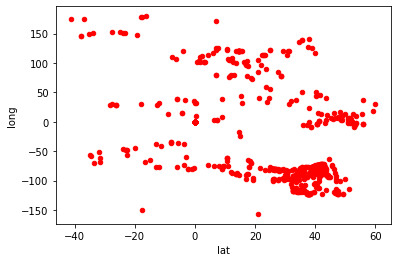

In [5]:
import matplotlib.pyplot as plt

df.plot(kind='scatter',x='lat',y='long',color='red')
plt.show()

# Using Kmean clustering to map outbreaks
## using elbow method to find amount of clusters

          lat       long
0    25.77427  -80.19366
1    40.71427  -74.00597
2    25.79065  -80.13005
3    -8.05389  -34.88111
4    32.78306  -96.80667
..        ...        ...
645  31.76904   35.21633
646  14.19528  120.87694
647 -18.14161  178.44149
648  18.45539  -69.94540
649  33.91371  -98.49339

[650 rows x 2 columns]
[[ 25.77427 -80.19366]
 [ 40.71427 -74.00597]
 [ 25.79065 -80.13005]
 ...
 [-18.14161 178.44149]
 [ 18.45539 -69.9454 ]
 [ 33.91371 -98.49339]]


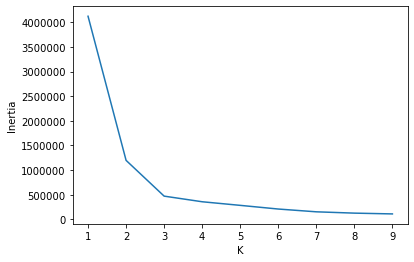

In [19]:
from sklearn.cluster import KMeans

coord = df[["lat","long"]].copy()
print(coord)
coordA = coord.to_numpy()
print(coordA)
k_values = range(1, 10)
inertia_values = [KMeans(k).fit(coordA).inertia_
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

# Elbow say 3 cluster

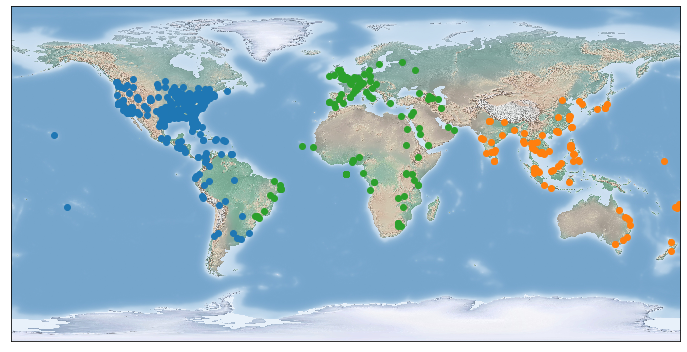

In [42]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
map_plotter = Basemap()
fig = plt.figure(figsize=(12, 8))

clusters=3

cluster_model = KMeans(n_clusters=clusters)
diseaseClusters = cluster_model.fit_predict(coordA)
map_plotter.shadedrelief()

for cluster_index in range(clusters):
    #print(diseaseClusters[cluster_index])
    selected_City = [coordA[i] for i in range(len(coordA))
                      if cluster_index == diseaseClusters[i]]
    
    latitudes, longitudes = np.array(selected_City).T
    map_plotter.scatter(longitudes, latitudes, latlon=True)

plt.show()


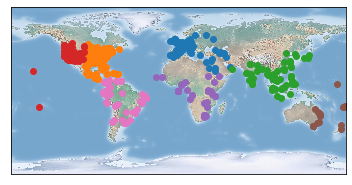

In [36]:
clusters=7

cluster_model = KMeans(n_clusters=clusters)
diseaseClusters = cluster_model.fit_predict(coordA)
map_plotter.shadedrelief()

for cluster_index in range(clusters):
    #print(diseaseClusters[cluster_index])
    selected_City = [coordA[i] for i in range(len(coordA))
                      if cluster_index == diseaseClusters[i]]
    
    latitudes, longitudes = np.array(selected_City).T
    map_plotter.scatter(longitudes, latitudes, latlon=True)

plt.show()

In [52]:
coords = df[["lat","long"]].copy()
print(coord)


kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))


          lat       long
0    25.77427  -80.19366
1    40.71427  -74.00597
2    25.79065  -80.13005
3    -8.05389  -34.88111
4    32.78306  -96.80667
..        ...        ...
645  31.76904   35.21633
646  14.19528  120.87694
647 -18.14161  178.44149
648  18.45539  -69.94540
649  33.91371  -98.49339

[650 rows x 2 columns]
Number of clusters: 28
